In [1]:
import h5py
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('/eagle/MDClimSim/mjp5595/ml4dvar/stormer/')
from stormer_utils_pangu import StormerWrapperPangu
from varsStormer import varsStormer

sys.path.append('/eagle/MDClimSim/mjp5595/ml4dvar/')
sys.path.append('/eagle/MDClimSim/mjp5595/ml4dvar/src')
from obs_cummulative import *

/home/mjp5595/.conda/envs/climaX/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/home/mjp5595/.conda/envs/climaX/lib/python3.8/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
def read_era5(data,vars_stormer):
    data_np = np.zeros((len(vars_stormer),128,256))
    for i,var in enumerate(vars_stormer):
        data_np[i] = data['input/{}'.format(var)][:]
    return data_np

vars_stormer = varsStormer().vars_stormer
vars_units = varsStormer().var_units

In [35]:
import torch

irga_obs = h5py.File("/eagle/MDClimSim/mjp5595/ml4dvar/obs/igra_141520_stormer_obs_standardized_360_3.hdf5")

era5_dir = '/eagle/MDClimSim/tungnd/data/wb2/1.40625deg_from_full_res_1_step_6hr_h5df/train/'
era5_2020_dir = '/eagle/MDClimSim/tungnd/data/wb2/1.40625deg_from_full_res_1_step_6hr_h5df/test/'

lats = np.linspace(-90,90,128)
lons = np.linspace(0,360,256)

means = np.load('/eagle/MDClimSim/tungnd/data/wb2/1.40625deg_from_full_res_1_step_6hr_h5df/normalize_mean.npz')
stds = np.load('/eagle/MDClimSim/tungnd/data/wb2/1.40625deg_from_full_res_1_step_6hr_h5df/normalize_std.npz')

#era5_obs = h5py.File('/eagle/MDClimSim/mjp5595/ml4dvar/data/era5_obs.h5', 'a')
with h5py.File('/eagle/MDClimSim/mjp5595/ml4dvar/obs/era5_obs.h5', 'w') as era5_obs:
    for year in ['2014','2015','2020']:
        yr_grp = era5_obs.require_group(year)
        year_hr_idx = 0
        for month in list(irga_obs['{}'.format(year)].keys()):
            mth_grp = era5_obs['{}'.format(year)].require_group(str(month))
            for day in list(irga_obs['{}/{}'.format(year,month)].keys()):
                day_grp = era5_obs['{}/{}'.format(year,month)].require_group(day)
                for hour in list(irga_obs['{}/{}/{}'.format(year,month,day)].keys()):
                    if int(hour) % 6 != 0:
                        continue

                    print('{}/{}/{}/{} - {:0>4d}'.format(year,month,day,hour,year_hr_idx))
                    hr_group = era5_obs['{}/{}/{}'.format(year,month,day)].require_group(hour)

                    # load era5
                    if year == '2014' or year == '2015':
                        try:
                            era5_data = torch.from_numpy(read_era5(h5py.File(os.path.join(era5_dir,'{}_{:0>4d}.h5'.format(year,year_hr_idx))),vars_stormer))
                        except:
                            continue
                    else:
                        try:
                            era5_data = torch.from_numpy(read_era5(h5py.File(os.path.join(era5_2020_dir,'{}_{:0>4d}.h5'.format(year,year_hr_idx))),vars_stormer))
                        except:
                            continue
                    year_hr_idx += 1

                    for var_idx,var in enumerate(vars_stormer):
                        irga_var_data = torch.from_numpy(irga_obs['{}/{}/{}/{}/{}'.format(year,month,day,hour,var)][:])
                        irga_var_data_H = torch.from_numpy(irga_obs['{}/{}/{}/{}/{}_H'.format(year,month,day,hour,var)][:])

                        n_obs = irga_var_data.shape[0]
                        h_idxs = torch.Tensor(irga_var_data_H[:,0]).to(torch.int)
                        h_obs = irga_var_data_H[:,1]
                        #print('irga_var_data.shape :',irga_var_data.shape)
                        #print('h_idxs.shape :',h_idxs)
                        #print('h_obs.shape :',h_obs)

                        era5_obs_ds = irga_var_data.clone()
                        x_obs = observe_linear(era5_data[var_idx].reshape(-1, 1),
                                            h_idxs[:4*n_obs].reshape(-1, 4).T,
                                            h_obs[:4*n_obs].reshape(-1, 4),
                                            )
                        x_obs = (x_obs - means[var]) / stds[var]
                        era5_obs_ds[:,2] = x_obs
                        #print('x_obs.shape min,max:',x_obs.shape,torch.min(x_obs),torch.max(x_obs))
                        #print('era5_obs_ds.shape :',era5_obs_ds.shape)

                        era5_obs_dataset = era5_obs['{}/{}/{}/{}'.format(year,month,day,hour)].create_dataset(
                            '{}'.format(var), data=era5_obs_ds, dtype = 'f8'
                        )
                        era5_obs_dataset_H = era5_obs['{}/{}/{}/{}'.format(year,month,day,hour)].create_dataset(
                            '{}_H'.format(var), data=irga_var_data_H, dtype = 'f8'
                        )


2014/01/01/00 - 0000
2014/01/01/06 - 0001


2014/01/01/12 - 0002
2014/01/01/18 - 0003
2014/01/02/00 - 0004
2014/01/02/06 - 0005
2014/01/02/12 - 0006
2014/01/02/18 - 0007
2014/01/03/00 - 0008
2014/01/03/06 - 0009
2014/01/03/12 - 0010
2014/01/03/18 - 0011
2014/01/04/00 - 0012
2014/01/04/06 - 0013
2014/01/04/12 - 0014
2014/01/04/18 - 0015
2014/01/05/00 - 0016
2014/01/05/06 - 0017
2014/01/05/12 - 0018
2014/01/05/18 - 0019
2014/01/06/00 - 0020
2014/01/06/06 - 0021
2014/01/06/12 - 0022
2014/01/06/18 - 0023
2014/01/07/00 - 0024
2014/01/07/06 - 0025
2014/01/07/12 - 0026
2014/01/07/18 - 0027
2014/01/08/00 - 0028
2014/01/08/06 - 0029
2014/01/08/12 - 0030
2014/01/08/18 - 0031
2014/01/09/00 - 0032
2014/01/09/06 - 0033
2014/01/09/12 - 0034
2014/01/09/18 - 0035
2014/01/10/00 - 0036
2014/01/10/06 - 0037
2014/01/10/12 - 0038
2014/01/10/18 - 0039
2014/01/11/00 - 0040
2014/01/11/06 - 0041
2014/01/11/12 - 0042
2014/01/11/18 - 0043
2014/01/12/00 - 0044
2014/01/12/06 - 0045
2014/01/12/12 - 0046
2014/01/12/18 - 0047
2014/01/13/00 - 0048
2014/01/13/06

In [3]:
irga_obs = h5py.File("/eagle/MDClimSim/mjp5595/ml4dvar/obs/igra_141520_stormer_obs_standardized_360_3.hdf5")

era5_dir = '/eagle/MDClimSim/tungnd/data/wb2/1.40625deg_from_full_res_1_step_6hr_h5df/train/'
era5_2020 = '/eagle/MDClimSim/tungnd/data/wb2/1.40625deg_from_full_res_1_step_6hr_h5df/test/'

lats = np.linspace(-90,90,128)
lons = np.linspace(0,360,256)

means = np.load('/eagle/MDClimSim/tungnd/data/wb2/1.40625deg_from_full_res_1_step_6hr_h5df/normalize_mean.npz')
stds = np.load('/eagle/MDClimSim/tungnd/data/wb2/1.40625deg_from_full_res_1_step_6hr_h5df/normalize_std.npz')

In [4]:
print('num_vars :',len(irga_obs['2014/01/01/12/'].keys()))
print('keys :',irga_obs['2014/01/01/00/'].keys())

temperature_obs = irga_obs['2014/01/01/12/2m_temperature/'][:]
print('temperature_obs.shape min,max:',temperature_obs.shape,np.min(temperature_obs[:,2]),np.max(temperature_obs[:,2]))

era5_0002 = read_era5(h5py.File(os.path.join(era5_dir,'{}_{:0>4d}.h5'.format(2014,2))),vars_stormer)
print('era5_0002.shape min,max:',era5_0002.shape,np.min(era5_0002[0]),np.max(era5_0002[0]))

#H_idxs_data = irga_obs['2014/01/01/12/2m_temperature/_H'][:, 0]
#H_idxs[step, j, 4*var_starts[j]:4*var_starts[j]+len(H_idxs_data)] = H_idxs_data
#H_obs_data = f[obs_datetime.strftime("%Y/%m/%d/%H") + '/' + var + '_H'][:, 1]
#H_obs[step, j, 4*var_starts[j]:4*var_starts[j]+len(H_obs_data)] = H_obs_data

num_vars : 138
keys : <KeysViewHDF5 ['10m_u_component_of_wind', '10m_u_component_of_wind_H', '10m_v_component_of_wind', '10m_v_component_of_wind_H', '2m_temperature', '2m_temperature_H', 'geopotential_100', 'geopotential_1000', 'geopotential_1000_H', 'geopotential_100_H', 'geopotential_150', 'geopotential_150_H', 'geopotential_200', 'geopotential_200_H', 'geopotential_250', 'geopotential_250_H', 'geopotential_300', 'geopotential_300_H', 'geopotential_400', 'geopotential_400_H', 'geopotential_50', 'geopotential_500', 'geopotential_500_H', 'geopotential_50_H', 'geopotential_600', 'geopotential_600_H', 'geopotential_700', 'geopotential_700_H', 'geopotential_850', 'geopotential_850_H', 'geopotential_925', 'geopotential_925_H', 'mean_sea_level_pressure', 'mean_sea_level_pressure_H', 'specific_humidity_100', 'specific_humidity_1000', 'specific_humidity_1000_H', 'specific_humidity_100_H', 'specific_humidity_150', 'specific_humidity_150_H', 'specific_humidity_200', 'specific_humidity_200_H', '

In [72]:
era5_obs = temperature_obs[:,2]
for i,(la,lo) in enumerate(zip(temperature_obs[:,0],temperature_obs[:,1])):
    era5_obs[i] = era5_0002[0,int(128*(la+90)/180),int(256*(lo/360))]

Text(0.5, 1.0, 'diff')

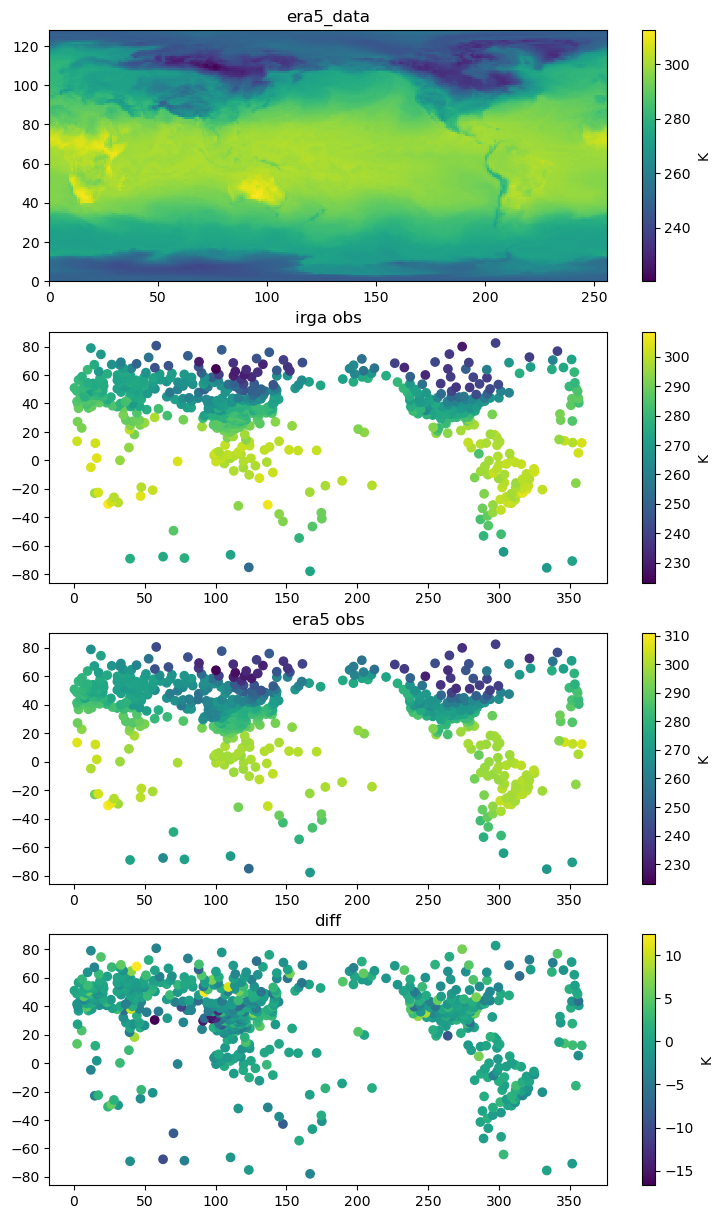

In [80]:
fig,axs = plt.subplots(4,1,figsize=(9,15))

ax0 = axs[0].pcolormesh(era5_0002[0])
plt.colorbar(ax0, ax = axs[0], label='K')
axs[0].set_title('era5_data')

ax1 = axs[1].scatter(temperature_obs[:,1],temperature_obs[:,0],c=(means['2m_temperature']+(stds['2m_temperature']*temperature_obs[:,2])))
plt.colorbar(ax1, ax = axs[1], label='K')
axs[1].set_title('irga obs')

ax2 = axs[2].scatter(temperature_obs[:,1],temperature_obs[:,0],c=era5_obs)
plt.colorbar(ax2, ax = axs[2], label='K')
axs[2].set_title('era5 obs')

ax3 = axs[3].scatter(temperature_obs[:,1],temperature_obs[:,0],c=era5_obs-(means['2m_temperature']+(stds['2m_temperature']*temperature_obs[:,2])))
plt.colorbar(ax3, ax = axs[3], label='K')
axs[3].set_title('diff')
